# CONCRETE HARNESS DATASET DEMO

## DATA AND EVOTREES MODEL

### Import data and required packages

In [1]:
using EvoTrees
using XLSX
using Plots
using Random
using Statistics
using Interpolations
include("plotting.jl")

xf = XLSX.readxlsx("data/Concrete_Data.xlsx");
data = Float64.(xf["Sheet1"]["A2:I1031"]);

### Split the concrete data into training and testing

In [2]:
Random.seed!(1)
data = data[shuffle(1:end), :]

split::Int = floor(0.75 * length(data[:, 1]))

x_train = data[1:split, 1:8];
y_train = data[1:split, 9];

x_test = data[split+1:end, 1:8];
y_test = data[split+1:end, 9];

### Get predictions from EvoTrees model with different forest sizes and tree depths

Testing part of data is used for calculating the coefficients of determination.

In [3]:
trees = [5, 10, 25, 50, 100, 200, 500, 1000, 2000]
depths = [3, 5, 7, 10]
r2_values_test = Matrix{Float64}(undef, length(trees), length(depths))

for depth in eachindex(depths)

    config = EvoTreeRegressor(nrounds=maximum(trees), max_depth=depths[depth]);
    model = fit_evotree(config; x_train, y_train);

    for n_trees in eachindex(trees)

        pred_train = EvoTrees.predict(model, x_train, ntree_limit=trees[n_trees])
        pred_test = EvoTrees.predict(model, x_test, ntree_limit=trees[n_trees])
    
        nrmse_train = sqrt(mean((y_train .- pred_train).^2)) / mean(y_train)
        nrmse_test = sqrt(mean((y_test .- pred_test).^2)) / mean(y_test)
    
        r2_score_train = 1 - sum((y_train .- pred_train).^2) / sum((y_train .- mean(y_train)).^2)
        r2_score_test = 1 - sum((y_test .- pred_test).^2) / sum((y_test .- mean(y_test)).^2)
    
        r2_values_test[n_trees, depth] = r2_score_test
    
    end

end

┌ Info: EvoTreeRegressor{EvoTrees.Linear, Float32}
│  - nrounds: 2000
│  - lambda: 0.0
│  - gamma: 0.0
│  - eta: 0.1
│  - max_depth: 3
│  - min_weight: 1.0
│  - rowsample: 1.0
│  - colsample: 1.0
│  - nbins: 32
│  - alpha: 0.5
│  - monotone_constraints: Dict{Int64, Int64}()
│  - rng: TaskLocalRNG()
│  - device: cpu
└ @ EvoTrees /Users/eetureijonen/.julia/packages/EvoTrees/eBGfO/src/fit.jl:323


┌ Info: EvoTreeRegressor{EvoTrees.Linear, Float32}
│  - nrounds: 2000
│  - lambda: 0.0
│  - gamma: 0.0
│  - eta: 0.1
│  - max_depth: 5
│  - min_weight: 1.0
│  - rowsample: 1.0
│  - colsample: 1.0
│  - nbins: 32
│  - alpha: 0.5
│  - monotone_constraints: Dict{Int64, Int64}()
│  - rng: TaskLocalRNG()
│  - device: cpu
└ @ EvoTrees /Users/eetureijonen/.julia/packages/EvoTrees/eBGfO/src/fit.jl:323


┌ Info: EvoTreeRegressor{EvoTrees.Linear, Float32}
│  - nrounds: 2000
│  - lambda: 0.0
│  - gamma: 0.0
│  - eta: 0.1
│  - max_depth: 7
│  - min_weight: 1.0
│  - rowsample: 1.0
│  - colsample: 1.0
│  - nbins: 32
│  - alpha: 0.5
│  - monotone_constraints: Dict{Int64, Int64}()
│  - rng: TaskLocalRNG()
│  - device: cpu
└ @ EvoTrees /Users/eetureijonen/.julia/packages/EvoTrees/eBGfO/src/fit.jl:323


┌ Info: EvoTreeRegressor{EvoTrees.Linear, Float32}
│  - nrounds: 2000
│  - lambda: 0.0
│  - gamma: 0.0
│  - eta: 0.1
│  - max_depth: 10
│  - min_weight: 1.0
│  - rowsample: 1.0
│  - colsample: 1.0
│  - nbins: 32
│  - alpha: 0.5
│  - monotone_constraints: Dict{Int64, Int64}()
│  - rng: TaskLocalRNG()
│  - device: cpu
└ @ EvoTrees /Users/eetureijonen/.julia/packages/EvoTrees/eBGfO/src/fit.jl:323


### Plot results in a (heavily) interpolated graph

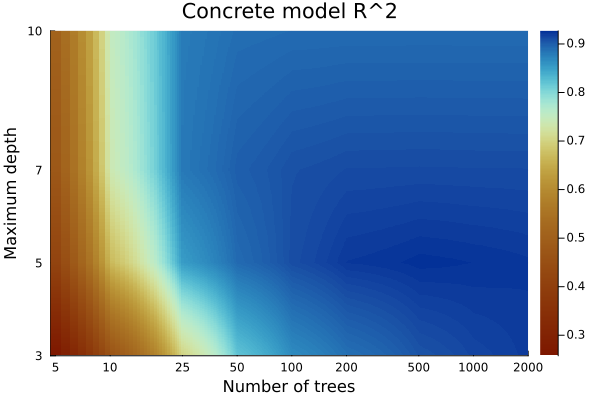

In [4]:
plot_model_quality(trees, depths, r2_values_test, "Concrete model R^2", "Number of trees", "Maximum depth")

From the graph it can be seen that the best results are achieved with forest sizes from $500$ to $1000$ and a maximum tree depth of $5$

Poorer performance of deeper trees might be explained by overfitting.

### Model prediction visualised

Let's train a model with $1000$ trees and maximum tree depth of $5$.

┌ Info: EvoTreeRegressor{EvoTrees.Linear, Float32}
│  - nrounds: 1000
│  - lambda: 0.0
│  - gamma: 0.0
│  - eta: 0.1
│  - max_depth: 5
│  - min_weight: 1.0
│  - rowsample: 1.0
│  - colsample: 1.0
│  - nbins: 32
│  - alpha: 0.5
│  - monotone_constraints: Dict{Int64, Int64}()
│  - rng: TaskLocalRNG()
│  - device: cpu
└ @ EvoTrees /Users/eetureijonen/.julia/packages/EvoTrees/eBGfO/src/fit.jl:323


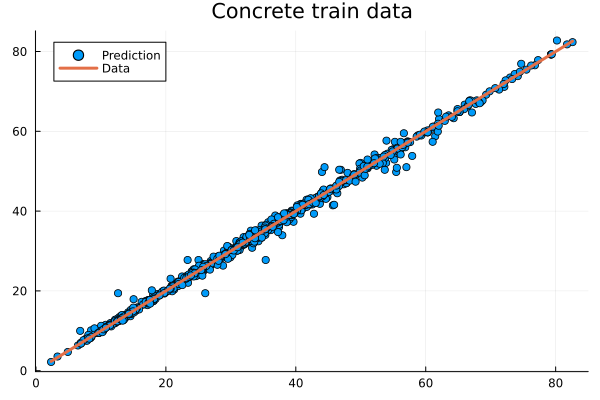

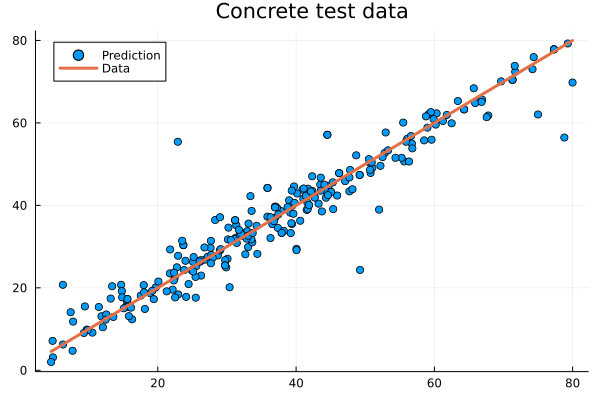

In [5]:
config = EvoTreeRegressor(nrounds=1000, max_depth=5);
model = fit_evotree(config; x_train, y_train);

pred_train = EvoTrees.predict(model, x_train)
pred_test = EvoTrees.predict(model, x_test)

display(plot(y_train, 
    [pred_train, y_train], 
    title="Concrete train data", 
    label=["Prediction" "Data"], 
    markershape=[:circle :none], 
    seriestype=[:scatter :line], 
    lw=3))

plot(y_test, 
    [pred_test, y_test], 
    title="Concrete test data", 
    label=["Prediction" "Data"], 
    markershape=[:circle :none], 
    seriestype=[:scatter :line], 
    lw=3)

## MODEL OPTIMIZATION

### Package import and optimization implementation

In [6]:
using JuMP
using Gurobi

include("trees_to_relaxed_op.jl");

## Optimization of the model

First let's generate all constraints

In [7]:
x_new, sol_new, m_new = trees_to_relaxed_MIP(model, :createinitial, 5, :max);

Set parameter Username
Academic license - for non-commercial use only - expires 2024-05-21
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[arm])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 29157 rows, 15169 columns and 98398 nonzeros
Model fingerprint: 0x10f2d136
Variable types: 14996 continuous, 173 integer (173 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-07, 4e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 67.9920948
Presolve removed 13159 rows and 8371 columns
Presolve time: 0.20s
Presolved: 15998 rows, 6798 columns, 59230 nonzeros
Variable types: 6487 continuous, 311 integer (311 binary)
Found heuristic solution: objective 68.9229401

Root relaxation: objective 1.610421e+02, 8846 iterations, 0.98 seconds (2.89 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work

Then let's use the split constraint generation algorithm

In [8]:
x_alg, sol_alg, m_algo = trees_to_relaxed_MIP(model, :noconstraints, 5, :max);

Set parameter Username
Academic license - for non-commercial use only - expires 2024-05-21
Set parameter LazyConstraints to value 1
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[arm])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1165 rows, 15169 columns and 15326 nonzeros
Model fingerprint: 0x68723642
Variable types: 14996 continuous, 173 integer (173 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-07, 4e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1165 rows, 15169 columns, 15326 nonzeros
Variable types: 14996 continuous, 173 integer (173 binary)

Root relaxation: objective 2.206613e+02, 0 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  220.6613

In [9]:
println("Prediction of EvoTrees model without algorithm: $(EvoTrees.predict(model, reshape([mean(x_new[n]) for n in 1:8], 1, 8))[1])")
println("Prediction of EvoTrees model with algorithm: $(EvoTrees.predict(model, reshape([mean(x_alg[n]) for n in 1:8], 1, 8))[1])")
println("Maximum conceivable sum of tree predictions: $(sum(maximum(model.trees[tree].pred) for tree in 1:1001))")
println("Objective value without algorithm: $sol_new")
println("Objective value with algorithm: $sol_alg")
println("Maximum of the test dataset: $(maximum(pred_test))")

Prediction of EvoTrees model without algorithm: 106.06263


Prediction of EvoTrees model with algorithm: 45.348034
Maximum conceivable sum of tree predictions: 220.66136
Objective value without algorithm: 131.947457918179
Objective value with algorithm: 212.83914565015584
Maximum of the test dataset: 79.26423


### Problems with the solutions

The predictions of the tree model don't match the objective values for the "optimal" solutions.

Suspected problem is that the optimization model finds a solution that is better than should be possible, i.e., not all necessary constraints are added/satisfied.

In [10]:
[mean(x_new[n]) for n in 1:8]

8-element Vector{Float64}:
  Inf
  Inf
 -Inf
 -Inf
   8.300000190734863
  Inf
 618.0562438964844
 140.0

In [11]:
x_new

8-element Vector{Vector}:
 [500.0, Inf]
 [282.79998779296875, Inf]
 [-Inf, 78.30000305175781]
 [-Inf, 145.89999389648438]
 [8.0, 8.600000381469727]
 [1119.90625, Inf]
 [611.7999877929688, 624.3125]
 [100.0, 180.0]